In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import scipy.stats as stats
from scipy.stats import mannwhitneyu, shapiro, levene, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel("all_vacancies.xlsx")
df.head()

,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url
0,117685242,Аналитик в практику Организационного консалтинга,RusPartners,Москва,"MS PowerPoint, Английский язык, Подготовка пре...",0.0,0.0,Нет опыта,Полный день,https://hh.ru/vacancy/117685242
1,117129644,Аналитик поддержки продукта Naumen Erudite,NAUMEN,Москва,NaN,0.0,0.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117129644
2,112418394,Системный аналитик (Стажер),Центр финансовых технологий,Владивосток,"Системный анализ, Бизнес-анализ, Аналитика",0.0,0.0,Нет опыта,Полный день,https://hh.ru/vacancy/112418394
3,117743231,Аналитик данных / Data Analyst,Saber Interactive,Санкт-Петербург,"SQL, Python, Clickhouse, Apache Airflow, Strea...",0.0,0.0,От 3 до 6 лет,Удаленная работа,https://hh.ru/vacancy/117743231
4,116150637,Бизнес-аналитик,Texnomart,Ташкент,NaN,0.0,0.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/116150637


In [ ]:
df.shape

(3150, 10)

In [ ]:
df['key_skills'] = df['key_skills'].fillna('Не указано')

In [ ]:
df['salary_from'] = df['salary_from'].fillna(0)
df['salary_to'] = df['salary_to'].fillna(0)

In [ ]:
df.loc[(df['salary_from'] == 0) & (df['salary_to'] != 0), 'salary_from'] = df['salary_to']
df.loc[(df['salary_to'] == 0) & (df['salary_from'] != 0), 'salary_to'] = df['salary_from']
df['salary'] = (df['salary_from'] + df['salary_to'])/2

In [ ]:
df = df[df['salary'] > 0]

In [ ]:
df.isnull().sum()

,0
id,0
name,0
company,0
city,0
key_skills,0
salary_from,0
salary_to,0
experience,0
schedule,0
alternate_url,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1363 entries, 8 to 3148
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1363 non-null   int64  
 1   name           1363 non-null   object 
 2   company        1363 non-null   object 
 3   city           1363 non-null   object 
 4   key_skills     1363 non-null   object 
 5   salary_from    1363 non-null   float64
 6   salary_to      1363 non-null   float64
 7   experience     1363 non-null   object 
 8   schedule       1363 non-null   object 
 9   alternate_url  1363 non-null   object 
 10  salary         1363 non-null   float64
dtypes: float64(3), int64(1), object(7)
memory usage: 127.8+ KB


In [ ]:
russian_cities = [
    'москва', 'санкт-петербург', 'владивосток', 'ростов-на-дону', 'нижний новгород',
    'екатеринбург', 'краснодар', 'новосибирск', 'самара', 'омск', 'челябинск', 'уфа',
    'калининград', 'волгоград', 'кемерово', 'севастополь', 'воронеж', 'красноярск',
    'обнинск', 'ярославль', 'симферополь', 'казань', 'южно-сахалинск', 'иркутск',
    'пермь', 'ковров', 'волжский (волгоградская область)', 'саратов', 'магнитогорск',
    'сочи', 'иваново (ивановская область)', 'владимир', 'киров (кировская область)',
    'чебоксары', 'зеленоград', 'тверь', 'тюмень', 'липецк', 'муром', 'димитровград',
    'благовещенск (амурская область)', 'энгельс', 'ульяановск', 'керчь', 'белгород',
    'барнаул', 'тула', 'тольятти', 'астрахань', 'шахты', 'кострома', 'рязань',
    'арзамас', 'махачкала', 'ижевск', 'брянск', 'пенза', 'грозный', 'вологда',
    'тамбов', 'великий новгород', 'улан-удэ', 'хабаровск', 'калуга', 'оренбург',
    'архангельск', 'пятигорск', 'набережные челны', 'орел', 'петропавловск-камчатский',
    'артем', 'салехард', 'таганрог', 'череповец', 'назрань', 'курск',
    'дзержинск (нижегородская область)', 'минеральные воды', 'курган', 'бийск',
    'ялта', 'йошкар-ола', 'серпухов (московская область)', 'старый оскол',
    'новомосковск (тульская область)', 'троицк (москва)', 'адлер', 'выселки',
    'королев (московская область)', 'березovsky (свердловская область)',
    'пушкино (московская область)', 'дубна (московская область)',
    'химки (московская область)', 'смоленск', 'саранск', 'невинномысск', 'качканар',
    'верхняя пышма', 'невинномысск'
]

print(russian_cities)

# Функция для определения, является ли город российским
def is_russian_city(city):
    if pd.isna(city):
        return False
    city = city.lower()
    return any(russian_city in city for russian_city in russian_cities)

# Оставляем только российские города
df_clean = df[df['city'].apply(is_russian_city)]

['москва', 'санкт-петербург', 'владивосток', 'ростов-на-дону', 'нижний новгород', 'екатеринбург', 'краснодар', 'новосибирск', 'самара', 'омск', 'челябинск', 'уфа', 'калининград', 'волгоград', 'кемерово', 'севастополь', 'воронеж', 'красноярск', 'обнинск', 'ярославль', 'симферополь', 'казань', 'южно-сахалинск', 'иркутск', 'пермь', 'ковров', 'волжский (волгоградская область)', 'саратов', 'магнитогорск', 'сочи', 'иваново (ивановская область)', 'владимир', 'киров (кировская область)', 'чебоксары', 'зеленоград', 'тверь', 'тюмень', 'липецк', 'муром', 'димитровград', 'благовещенск (амурская область)', 'энгельс', 'ульяановск', 'керчь', 'белгород', 'барнаул', 'тула', 'тольятти', 'астрахань', 'шахты', 'кострома', 'рязань', 'арзамас', 'махачкала', 'ижевск', 'брянск', 'пенза', 'грозный', 'вологда', 'тамбов', 'великий новгород', 'улан-удэ', 'хабаровск', 'калуга', 'оренбург', 'архангельск', 'пятигорск', 'набережные челны', 'орел', 'петропавловск-камчатский', 'артем', 'салехард', 'таганрог', 'черепове

In [ ]:
# Выводим количество оставшихся строк
print(f"\nКоличество строк после фильтрации российских городов: {len(df_clean)}")

# Выводим распределение по городам
print("\nРаспределение по городам:")
print(df_clean['city'].value_counts())

# Проверяем средние зарплаты по городам
city_salary = df_clean.groupby('city')[['salary_from','salary','salary_to']].mean().reset_index()
print("\nСредние зарплаты по городам:")
print(city_salary.sort_values(by='salary_from', ascending=False))


Количество строк после фильтрации российских городов: 1163

Распределение по городам:
city
Москва                           496
Санкт-Петербург                  141
Екатеринбург                      51
Казань                            39
Нижний Новгород                   38
                                ... 
Серпухов (Московская область)      1
Курган                             1
Курск                              1
Ялта                               1
Петропавловск-Камчатский           1
Name: count, Length: 82, dtype: int64

Средние зарплаты по городам:
                                 city    salary_from         salary  \
68                    Троицк (Москва)  180000.000000  180000.000000   
38                             Москва  174193.354839  181886.247984   
53                           Салехард  157000.000000  157000.000000   
74         Химки (Московская область)  150000.000000  150000.000000   
80                               Ялта  150000.000000  150000.000000   
..     

In [ ]:
# Распределяем по федеральным округам
Мск_МО = ['Москва','Мытищи (Московская область)', 'Одинцово (Московская область)', 'Подольск (Московская область)', 'Кокошкино (Московская область)', 'Киевский (Московская область)', 'Домодедово (Московская область)', 'Электрогорск (Московская область)', 'Сергиев Посад (Московская область)', 'Троицк (Москва)', 'Дубна (Московская область)', 'Химки (Московская область)', 'Наро-Фоминск (Московская область)', 'Серпухов (Московская область)']
СПб = ['Санкт-Петербург']
ЦФО = ['Воронеж', 'Обнинск', 'Ярославль', 'Ковров', 'Иваново (Ивановская область)', 'Владимир', 'Липецк', 'Муром', 'Белгород', 'Рыбинск', 'Тверь', 'Кострома', 'Рязань', 'Киржач', 'Тамбов', 'Тула', 'Старый Оскол', 'Калуга', 'Новомосковск (Тульская область)', 'Боровляны', 'Смоленск', 'Курск']
СЗФО = ['Калининград', 'Вологда', 'Архангельск', 'Череповец']
ЮФО = ['Ростов-на-Дону', 'Волжский (Волгоградская область)', 'Сочи', 'Краснодар', 'Симферополь', 'Севастополь', 'Керчь', 'Волгоград', 'Астрахань', 'Шахты', 'Невинномысск', 'Адлер', 'Выселки', 'Сириус', 'Ялта', 'Майкоп']
СКФО = ['Ставрополь', 'Грозный', 'Махачкала', 'Назрань']
ПФО = ['Нижний Новгород', 'Казань', 'Самара', 'Киров (Кировская область)', 'Энгельс', 'Ульяновск', 'Тольятти', 'Уфа', 'Пермь', 'Чусовой', 'Чебоксары', 'Саратов', 'Иннополис', 'Ижевск', 'Бор', 'Оренбург', 'Набережные Челны', 'Саранск', 'Дзержинск (Нижегородская область)']
УФО = ['Екатеринбург', 'Челябинск', 'Тюмень', 'Качканар', 'Верхняя Пышма', 'Березовский (Свердловская область)', 'Салехард', 'Красноуральск', 'Курган']
СФО = ['Кемерово', 'Новосибирск', 'Иркутск', 'Томск', 'Красноярск', 'Барнаул', 'Улан-Удэ', 'Омск', 'Бийск']
ДФО = ['Владивосток', 'Благовещенск (Амурская область)', 'Хабаровск', 'Долинск', 'Артем', 'Петропавловск-Камчатский']

In [ ]:
def area(x):
  if x in Мск_МО:
    return 'Мск_МО'
  elif x in СПб:
    return 'СПб'
  elif x in ЦФО:
    return 'ЦФО'
  elif x in СЗФО:
    return 'СЗФО'
  elif x in ЮФО:
    return 'ЮФО'
  elif x in СКФО:
    return 'СКФО'
  elif x in ПФО:
    return 'ПФО'
  elif x in УФО:
    return 'УФО'
  elif x in СФО:
    return 'СФО'
  elif x in ДФО:
    return 'ДФО'
  else:
    return None

In [ ]:
df_clean['area'] = df_clean['city'].apply(area)

<ipython-input-17-4b278076a659>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['area'] = df_clean['city'].apply(area)


In [ ]:
# Выводим распределение по федеральным округам
print("\nРаспределение по федеральным округам:")
print(df_clean['area'].value_counts())

# Проверяем средние зарплаты по федеральным округам
city_salary = df_clean.groupby('area')[['salary_from', 'salary', 'salary_to']].mean().reset_index()
print("\nСредние зарплаты по федеральным округам:")
print(city_salary.sort_values(by='salary', ascending=False))


Распределение по федеральным округам:
area
Мск_МО    500
ПФО       152
СПб       141
ЦФО        87
ЮФО        84
УФО        82
СФО        79
ДФО        22
СЗФО       12
СКФО        4
Name: count, dtype: int64

Средние зарплаты по федеральным округам:
     area    salary_from         salary      salary_to
1  Мск_МО  173808.808000  181440.158000  189071.508000
5     СПб  106629.226950  113262.425532  119895.624113
7     УФО   86645.243902   90665.487805   94685.731707
0     ДФО   83400.000000   88763.636364   94127.272727
6     СФО   80163.291139   84312.658228   88462.025316
2     ПФО   77900.328947   84143.750000   90387.171053
9     ЮФО   78245.952381   83672.142857   89098.333333
8     ЦФО   77000.000000   80854.022989   84708.045977
3    СЗФО   76000.000000   79791.666667   83583.333333
4    СКФО   37500.000000   56875.000000   76250.000000


In [ ]:
# Функция для удаления выбросов с помощью IQR и минимального порога
def remove_outliers_with_min_threshold(df, column, min_threshold):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = max(Q1 - 1.5 * IQR, min_threshold)  # Устанавливаем нижнюю границу не ниже min_threshold
    upper_bound = Q3 + 1.5 * IQR
    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_no_outliers

df_clean = remove_outliers_with_min_threshold(df_clean, 'salary', 20000) # Граница для зп в рублях

print(f"Количество строк после удаления выбросов: {len(df_clean)}")

# Проверяем минимальные и максимальные значения зарплат
print(f"Минимальная salary: {df_clean['salary'].min()}")
print(f"Максимальная salary: {df_clean['salary'].max()}")

Количество строк после удаления выбросов: 1085
Минимальная salary: 20000.0
Максимальная salary: 220000.0


In [ ]:
vt = pd.read_excel("all_vacancies_type.xlsx")
vt.head()

,id,Vacancy type
0,114673345,BI-аналитик
1,117262495,Финансовый аналитик
2,116537974,Системный аналитик
3,117148794,Аналитик маркетплейсов
4,116518807,Другое


In [ ]:
df_clean = pd.merge(df_clean, vt, on = 'id', how = 'left')

In [ ]:
df_clean.sort_values(['salary'])

,id,name,company,city,key_skills,salary_from,salary_to,experience,schedule,alternate_url,salary,area,Vacancy type
953,117141728,Аналитик - специалист по работе с данными на м...,Овчинникова Татьяна Олеговна,Москва,"MS PowerPoint, Исследовательский анализ данных...",20000.0,20000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117141728,20000.0,Мск_МО,Аналитик маркетплейсов
1049,102417762,Аналитик,Санкт-Петербургский государственный экономичес...,Санкт-Петербург,"Работа с большим объемом информации, Исполните...",24040.0,24040.0,Нет опыта,Полный день,https://hh.ru/vacancy/102417762,24040.0,СПб,Другое
249,117015823,Экономист-аналитик,Комус,Волгоград,MS Excel,24700.0,24700.0,Нет опыта,Полный день,https://hh.ru/vacancy/117015823,24700.0,ЮФО,Другое
71,117063054,Аналитик,Гриневич Иван Витальевич,Москва,Не указано,25000.0,25000.0,От 1 года до 3 лет,Удаленная работа,https://hh.ru/vacancy/117063054,25000.0,Мск_МО,Другое
213,117752049,Специалист по фитнес-аналитике,СП Рустат,Чебоксары,"Работа с большим объемом информации, Обучение ...",25000.0,25000.0,Нет опыта,Удаленная работа,https://hh.ru/vacancy/117752049,25000.0,ПФО,Другое
...,...,...,...,...,...,...,...,...,...,...,...,...,...
927,117365348,Консультант-аналитик по внедрению информационн...,Timetta,Москва,"Бизнес-анализ, REST API, JSON API, Системный а...",210000.0,210000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117365348,210000.0,Мск_МО,Продуктовый аналитик
423,117010349,Бизнес/Системный аналитик,1С:ВДГБ,Москва,Не указано,220000.0,220000.0,От 3 до 6 лет,Удаленная работа,https://hh.ru/vacancy/117010349,220000.0,Мск_МО,Системный аналитик
608,117382066,Старший аналитик (в департамент стратегическог...,Инфра Проекты,Москва,"Анализ инвестиционных проектов, Стратегическое...",220000.0,220000.0,От 3 до 6 лет,Полный день,https://hh.ru/vacancy/117382066,220000.0,Мск_МО,Финансовый аналитик
233,117015712,Аналитик бизнес-процессов,TRUCK RADAR,Москва,"Базы данных, Работа с базами данных, Прогнозир...",220000.0,220000.0,От 1 года до 3 лет,Полный день,https://hh.ru/vacancy/117015712,220000.0,Мск_МО,Бизнес аналитик


Проверка гипотез

Гипотеза 1: U-тест Манна-Уитни, p-value = 0.0000


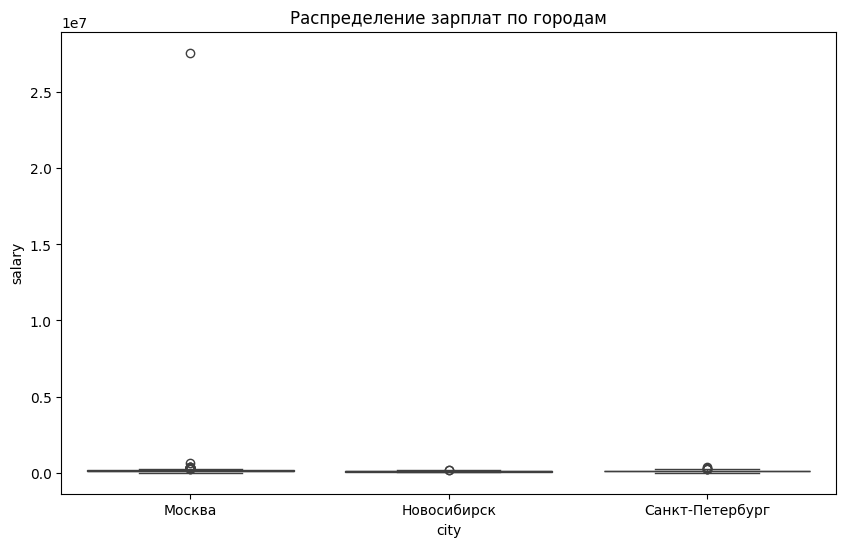

In [40]:
# -------------------------------------------
# Гипотеза 1: Зарплаты в Москве значимо выше
# -------------------------------------------

# Разделение на группы
moscow_salary = df[df['city'] == 'Москва']['salary']
other_salary = df[df['city'] != 'Москва']['salary']

# Тест Манна-Уитни
u_stat, p_val = mannwhitneyu(moscow_salary, other_salary, alternative='greater')
test_type = "U-тест Манна-Уитни"

print(f"Гипотеза 1: {test_type}, p-value = {p_val:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='city', y='salary', data=df[df['city'].isin(['Москва', 'Санкт-Петербург', 'Новосибирск'])])
plt.title('Распределение зарплат по городам')
plt.show()

По результатам можно отвергнуть нулевую гипотезу (p-value < 0.05), что означает, что зарплаты в Москве статистически значимо выше, чем в других городах.

Гипотеза 2: U-тест Манна-Уитни, p-value = 0.8139


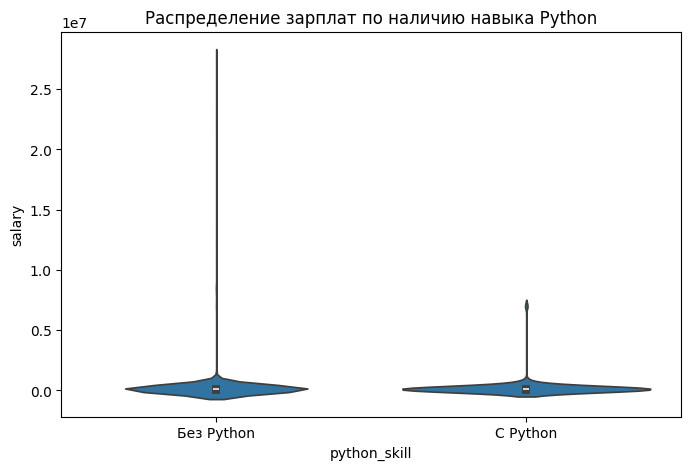

In [41]:
# -------------------------------------------
# Гипотеза 2: Навык Python связан с зарплатой
# -------------------------------------------

df['python_skill'] = df['key_skills'].str.contains('Python', case=False).astype(int)

python_salary = df[df['python_skill'] == 1]['salary']
no_python_salary = df[df['python_skill'] == 0]['salary']

# Тест Манна-Уитни
u_stat, p_val = mannwhitneyu(python_salary, no_python_salary, alternative='greater')
print(f"Гипотеза 2: U-тест Манна-Уитни, p-value = {p_val:.4f}")

plt.figure(figsize=(8, 5))
sns.violinplot(x='python_skill', y='salary', data=df)
plt.xticks([0, 1], ['Без Python', 'С Python'])
plt.title('Распределение зарплат по наличию навыка Python')
plt.show()

Результаты U-теста Манна-Уитни (p-value = 0.8139) не позволяют отвергнуть нулевую гипотезу. Статистически значимых различий в зарплатах между группами с навыком Python и без него не обнаружено.

Гипотеза 3: U-тест Манна-Уитни, p-value = 0.0009


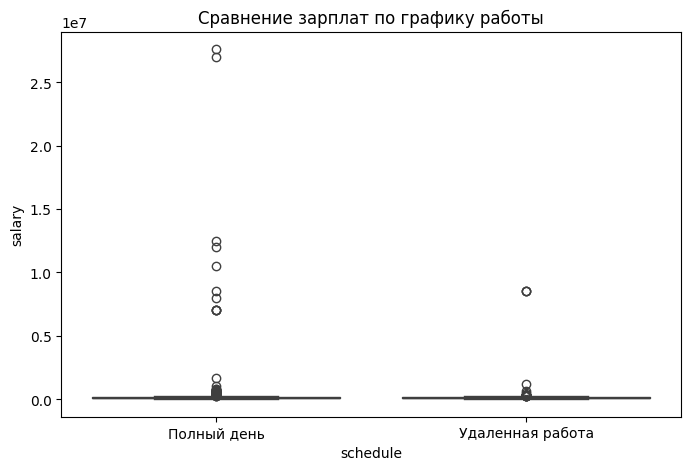

In [42]:
# -------------------------------------------
# Гипотеза 3: Удаленная работа и зарплата
# -------------------------------------------

remote_salary = df[df['schedule'] == 'Удаленная работа']['salary']
office_salary = df[df['schedule'] == 'Полный день']['salary']

# Тест Манна-Уитни
u_stat, p_val = mannwhitneyu(remote_salary, office_salary, alternative='two-sided')
print(f"Гипотеза 3: U-тест Манна-Уитни, p-value = {p_val:.4f}")

plt.figure(figsize=(8, 5))
sns.boxplot(x='schedule', y='salary', data=df[df['schedule'].isin(['Удаленная работа', 'Полный день'])])
plt.title('Сравнение зарплат по графику работы')
plt.show()

Результаты U-теста Манна-Уитни (p-value = 0.0009) позволяют отвергнуть нулевую гипотезу и подтверждают наличие статистически значимых различий в зарплатах между удаленной и офисной работой. Причем зарплаты для вакансий с удаленным форматом ниже, чем вакансии на полный день